## Unconstrained wake steering optimization

In TOPFARM, it is also possible to perform an active yaw control optimization, or wake steering, where the objective function is still the AEP but now the turbines are allowed to yaw to find a better configuration and increase the AEP of a wind farm.

When using yaw angles as design variables, it is important to include a wake deflection model, as this will allow for a more accurate representation of the wake behind a turbine when subject to yaw misalignment.

**Install Topfarm if needed**

In [ ]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

We import first the site and wind turbines to use as well as the [Jimenez wake deflection](https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/EngineeringWindFarmModels.html#JimenezWakeDeflection) model. In addition, we import the `CostModelComponent` to use for the optimization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
from py_wake.examples.data.lillgrund import LillgrundSite
from py_wake.deflection_models.jimenez import JimenezWakeDeflection
from py_wake.examples.data.iea37 import IEA37_WindTurbines
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian

from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm import TopFarmProblem
from topfarm.plotting import NoPlot
from topfarm.easy_drivers import EasyScipyOptimizeDriver

We set up the site and wind turbines to use. In this example, we will use the **Lillgrund** site with **IEA 3.4MW** wind turbines. Since the yaw angles depend on the number of turbines, wind speed and wind directions studied, these must be selected before using PyWake's wind farm simulation tool.

In [3]:
site = LillgrundSite()
windTurbines = IEA37_WindTurbines()

wf_model = IEA37SimpleBastankhahGaussian(site, windTurbines,deflectionModel=JimenezWakeDeflection())

#choosing the flow cases for the optimization
wsp = np.asarray([10])
wdir = np.asarray([270])

#getting initial position of turbines
x,y = site.initial_position.T
x = x[::2]
y = y[::2]
n_wt = x.size

#setting up yaw angles for each turbine, wind direction and wind speed
i = n_wt
k = wsp.size
l = wdir.size
yaw_zero = np.zeros((i,l,k))  #initial condition of yaw angles

Now we can set up our AEP function, that calculates the AEP of each turbine while considering the yaw angles.

In [4]:
def aep_func(yaw_ilk):
    simres = wf_model(x,y,wd=wdir,ws=wsp,yaw=yaw_ilk, tilt=0)
    aep = simres.aep().sum()
    return aep

Specifying the cost component and topfarm problem

In [5]:
cost_comp = CostModelComponent(input_keys=[('yaw_ilk', np.zeros((i, l, k)))],
                                          n_wt = n_wt,
                                          cost_function = aep_func,
                                          objective=True,
                                          maximize=True,
                                          output_keys=[('AEP', 0)]
                                          )

maxiter=100
tol=1e-4
ec=1e-4

problem = TopFarmProblem(design_vars={'yaw_ilk': (yaw_zero, -30, 30)},  #setting up initial values and lower and upper bounds for yaw angles
                          n_wt=n_wt,
                          cost_comp=cost_comp,
                          driver=EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=maxiter, tol=tol),
                          plot_comp=NoPlot(),
                          expected_cost=ec)

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


In [6]:
_, state,_ = problem.optimize()

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


C:\Users\mavar\Anaconda3\envs\topfarm\lib\site-packages\openmdao\core\total_jac.py:1564: DerivativesWarning:Design variables [('indeps.yaw_ilk', inds=[(0, 0, 0), (1, 0, 0), (2, 0, 0), (3, 0, 0)])] have no impact on the constraints or objective.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1384843.7305931787
            Iterations: 42
            Function evaluations: 130
            Gradient evaluations: 42
Optimization Complete
-----------------------------------


Now we can plot the wake map of the wind farm to visualize the final yaw angles of each turbine.

Text(0, 0.5, 'y [m]')

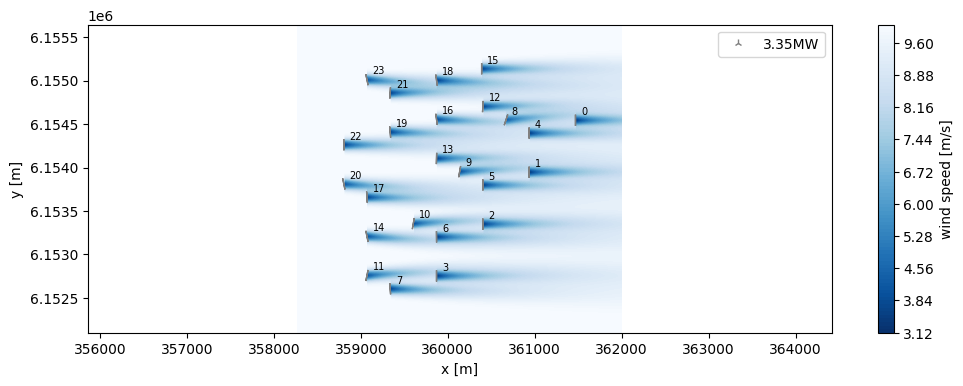

In [7]:
# simulationResult = wf_model(x,y,wd=wdir[0], ws=wsp[0], yaw=state['yaw_ilk'][:,0,0], tilt=0)
# plt.figure(figsize=(12,4))
# simulationResult.flow_map().plot_wake_map()
# plt.xlabel('x [m]')
# plt.ylabel('y [m]')